# packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.spatial.distance import pdist, squareform
import plotly.express as px
import yfinance as yf
import vectorbt as vbt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
import pickle


# data audit

In [2]:
df = pd.read_csv('../data/uni_usd_combined_df_1_level_cols.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20736 entries, 0 to 20735
Columns: 174 entries, custom_window_entry_identify to Rank_pct_diff_max
dtypes: float64(152), int64(8), object(14)
memory usage: 27.5+ MB


In [4]:
df.head()

,custom_window_entry_identify,custom_window_entry_count,custom_hh_hl_counts,custom_window_exit_identify,custom_window_exit_count,custom_lh_counts,Total Return [%]_in_count,Total Return [%]_in_mean,Total Return [%]_in_std,Total Return [%]_in_min,...,Sharpe Ratio_pct_diff_75%,Sharpe Ratio_pct_diff_max,Rank_pct_diff_count,Rank_pct_diff_mean,Rank_pct_diff_std,Rank_pct_diff_min,Rank_pct_diff_25%,Rank_pct_diff_50%,Rank_pct_diff_75%,Rank_pct_diff_max
0,3,3,1,3,3,1,10.0,-99.927720,0.200704,-99.999851,...,2.644003,3.985670,10.0,-0.301957,0.234006,-0.712749,-0.428233,-0.348047,-0.157244,0.031467
1,3,3,1,3,3,2,10.0,-99.988217,0.032318,-99.999881,...,3.830210,6.829557,10.0,-0.100501,0.521553,-0.768594,-0.273352,-0.221378,-0.056079,0.793418
2,3,3,1,3,3,3,10.0,-99.981366,0.040854,-99.999370,...,2.938025,16.236892,10.0,0.627153,0.923860,-0.606392,-0.218812,0.636366,1.241666,2.151945
3,3,3,1,3,3,4,10.0,-72.999304,23.009774,-98.400290,...,-0.484192,1.535384,10.0,5.663833,6.649882,-0.421962,-0.223903,2.807305,11.860783,14.502890
4,3,3,1,3,4,1,10.0,-99.927720,0.200704,-99.999851,...,2.644003,3.985670,10.0,-0.301957,0.234006,-0.712749,-0.428233,-0.348047,-0.157244,0.031467


In [5]:
df.columns.tolist()

['custom_window_entry_identify',
 'custom_window_entry_count',
 'custom_hh_hl_counts',
 'custom_window_exit_identify',
 'custom_window_exit_count',
 'custom_lh_counts',
 'Total Return [%]_in_count',
 'Total Return [%]_in_mean',
 'Total Return [%]_in_std',
 'Total Return [%]_in_min',
 'Total Return [%]_in_25%',
 'Total Return [%]_in_50%',
 'Total Return [%]_in_75%',
 'Total Return [%]_in_max',
 'Max Drawdown [%]_in_count',
 'Max Drawdown [%]_in_mean',
 'Max Drawdown [%]_in_std',
 'Max Drawdown [%]_in_min',
 'Max Drawdown [%]_in_25%',
 'Max Drawdown [%]_in_50%',
 'Max Drawdown [%]_in_75%',
 'Max Drawdown [%]_in_max',
 'Max Drawdown Duration_in_count',
 'Max Drawdown Duration_in_mean',
 'Max Drawdown Duration_in_std',
 'Max Drawdown Duration_in_min',
 'Max Drawdown Duration_in_25%',
 'Max Drawdown Duration_in_50%',
 'Max Drawdown Duration_in_75%',
 'Max Drawdown Duration_in_max',
 'Total Trades_in_count',
 'Total Trades_in_mean',
 'Total Trades_in_std',
 'Total Trades_in_min',
 'Total Tra

In [6]:
df.isna().sum().sum()

98592

In [7]:
df.isna().sum().sort_values(ascending=False)

Win Rate [%]_out_std         1692
Win Rate [%]_out_25%         1692
Win Rate [%]_pct_diff_min    1692
Win Rate [%]_pct_diff_25%    1692
Win Rate [%]_pct_diff_50%    1692
                             ... 
Rank_in_max                     0
Rank_in_75%                     0
Rank_in_50%                     0
Rank_in_25%                     0
Rank_pct_diff_max               0
Length: 174, dtype: int64

In [8]:
df.replace([np.inf, -np.inf], np.nan).isna().sum().sum()

105144

# filters

In [9]:
# params with positive SR and total return on in sample and out of sample periods
# params with low std of SR and total returns
# drop inf
# too low of number of trades

In [10]:
min_trades_in_min = 20 # params with min traces count 20
min_trades_out_min = 15
mean_sr_in_min = 1.2 # params with minimum sharpe ratio of 1.2
mean_sr_out_min = 0.9
std_sr_in_max = 0.5 # params with maximun standard deviation of sharpe ratio of 0.18
std_sr_out_max = 0.3
min_sr_in_min = 0 # params with minimum of sharpe ratio of 0
min_sr_out_min = 0
min_tr_in_min = 0 # params with minimum of total return of 0
min_tr_out_min = 0



In [11]:
df_f = df.loc[(df['Sharpe Ratio_in_min'] > min_sr_in_min) & (df['Sharpe Ratio_out_min'] > min_sr_out_min), :]
df_f = df_f.loc[(df_f['Total Return [%]_in_min'] > min_tr_in_min) & (df_f['Total Return [%]_out_min'] > min_tr_out_min), :]
df_f = df_f.replace([np.inf, -np.inf], np.nan).dropna()


In [12]:
df_f.shape

(0, 174)

In [13]:
condition = (df_f['Sharpe Ratio_in_min'] > min_sr_in_min) & (df_f['Sharpe Ratio_out_min'] > min_sr_out_min) & \
    (df_f['Total Trades_in_min'] > min_trades_in_min) & (df_f['Total Trades_out_min'] > min_trades_out_min) & \
    (df_f['Sharpe Ratio_in_mean'] > mean_sr_in_min) &  (df_f['Sharpe Ratio_out_mean'] > mean_sr_out_min) & \
    (df_f['Sharpe Ratio_in_std'] < std_sr_in_max) &  (df_f['Sharpe Ratio_out_std'] < std_sr_in_max)
condition.sum()

0

In [14]:
df_final = df_f[condition]
df_final

,custom_window_entry_identify,custom_window_entry_count,custom_hh_hl_counts,custom_window_exit_identify,custom_window_exit_count,custom_lh_counts,Total Return [%]_in_count,Total Return [%]_in_mean,Total Return [%]_in_std,Total Return [%]_in_min,...,Sharpe Ratio_pct_diff_75%,Sharpe Ratio_pct_diff_max,Rank_pct_diff_count,Rank_pct_diff_mean,Rank_pct_diff_std,Rank_pct_diff_min,Rank_pct_diff_25%,Rank_pct_diff_50%,Rank_pct_diff_75%,Rank_pct_diff_max
239,3,3,2,6,8,4,10.0,487.630566,196.303754,218.318266,...,-0.119019,0.004531,10.0,0.168680,0.993298,-0.725839,-0.552973,-0.229258,0.916984,1.929768
879,3,4,3,3,6,4,10.0,452.703483,99.287783,327.273964,...,-0.089998,0.281192,10.0,-0.126211,0.589109,-0.912914,-0.573262,-0.186951,0.307107,0.949730
911,3,4,3,4,8,4,10.0,280.313451,79.104551,174.512165,...,0.086394,0.762899,10.0,-0.437670,0.320947,-0.890336,-0.582446,-0.433723,-0.320139,0.239862
935,3,4,3,5,8,4,10.0,279.773022,79.786381,174.512165,...,0.104707,0.777488,10.0,-0.480934,0.291130,-0.891049,-0.591403,-0.468022,-0.395853,0.158441
955,3,4,3,6,7,4,10.0,343.608750,66.373046,247.452415,...,-0.016548,0.492189,10.0,-0.090359,0.869806,-0.913030,-0.559970,-0.222250,-0.010716,2.142222
1465,3,5,3,4,3,2,10.0,381.301503,168.161900,204.426501,...,0.027907,0.263736,10.0,-0.195429,0.576852,-0.842847,-0.654585,-0.335624,0.229139,0.884643
1537,3,5,3,7,3,2,10.0,368.226647,138.569857,200.061353,...,0.034027,0.297370,10.0,-0.261627,0.482245,-0.815622,-0.590716,-0.438433,-0.002222,0.662986
3715,4,3,2,7,7,4,10.0,501.012482,146.842703,270.881439,...,-0.025480,0.156149,10.0,-0.178181,0.511746,-0.703402,-0.474820,-0.322006,-0.177224,0.921432
18592,8,5,2,3,7,1,10.0,569.360090,252.235892,226.969869,...,-0.111214,0.102875,10.0,0.772793,1.418657,-0.781702,-0.550667,0.647181,1.620942,3.238766
18593,8,5,2,3,7,2,10.0,573.216431,256.429010,226.969869,...,-0.111214,0.097699,10.0,0.802189,1.452392,-0.781702,-0.542101,0.670443,1.690174,3.382471


# clustering


In [15]:
df_f = df.loc[(df['Sharpe Ratio_in_min'] > min_sr_in_min) & (df['Sharpe Ratio_out_min'] > min_sr_out_min), :]
df_f = df_f.loc[(df_f['Total Return [%]_in_min'] > min_tr_in_min) & (df_f['Total Return [%]_out_min'] > min_tr_out_min), :]
df_f = df_f.replace([np.inf, -np.inf], np.nan).dropna()
df_f_params = df_f.iloc[:, :6].reset_index(drop = True)
df_f = df_f.iloc[:, 6:].reset_index(drop = True)

count_cols = [col for col in df_f.columns.tolist() if 'count' in col]
df_f.drop(columns = count_cols, inplace=True)

drawdown_cols = [col for col in df_f.columns.tolist() if 'Max Drawdown Duration' in col and 'pct_diff' not in col]
df_f[drawdown_cols] = df_f[drawdown_cols].apply(lambda col: pd.to_timedelta(col))
df_f[drawdown_cols] = df_f[drawdown_cols].apply(lambda col: col.dt.total_seconds() / (24*60*60))

In [16]:
# adding std as %

columns_to_describe = ['Total Return [%]', 'Max Drawdown [%]', 'Max Drawdown Duration', 'Total Trades', 'Win Rate [%]', 'Sharpe Ratio', 'Rank']
added_cols_std_perc = [f"{col}_in_std_perc" for col in columns_to_describe]
added_cols_std_perc = added_cols_std_perc + [f"{col}_out_std_perc" for col in columns_to_describe]
std_cols = [col for col in df_f.columns.tolist() if '_std' in col and 'pct_diff' not in col]
median_cols = [col for col in df_f.columns.tolist() if '_50%' in col and 'pct_diff' not in col]
df_f[added_cols_std_perc] = df_f[std_cols].values/df_f[median_cols].replace(0, np.nan).values

In [17]:
# drop absolute std cols

df_f.drop(columns = std_cols, inplace = True)

In [18]:
df_f.shape

(2280, 147)

In [19]:
# to filter variables (same as in profile)

cols_to_cluster = ['Total Return [%]_in_mean', 'Sharpe Ratio_in_mean', 'Max Drawdown [%]_in_mean', 
                    'Total Trades_in_mean', 'Total Return [%]_in_std_perc', 'Sharpe Ratio_in_std_perc',
                    'Total Return [%]_pct_diff_mean', 'Sharpe Ratio_pct_diff_mean', 'Max Drawdown [%]_pct_diff_mean', 
                    'Total Trades_pct_diff_mean', 'Total Return [%]_pct_diff_std', 'Sharpe Ratio_pct_diff_std',
                    'Sharpe Ratio_in_min', 'Total Return [%]_in_min', 'Total Trades_in_min',
                    'Sharpe Ratio_pct_diff_min', 'Total Return [%]_pct_diff_min', 'Total Trades_pct_diff_min',
                    'Max Drawdown [%]_in_max', 'Max Drawdown [%]_pct_diff_max']
df_f = df_f[cols_to_cluster]

In [44]:
x_minmax = MinMaxScaler().fit_transform(df_f)
max_clusters = 40
n_init = 100

x_minmax.shape

(2280, 20)

## calinski harabasz

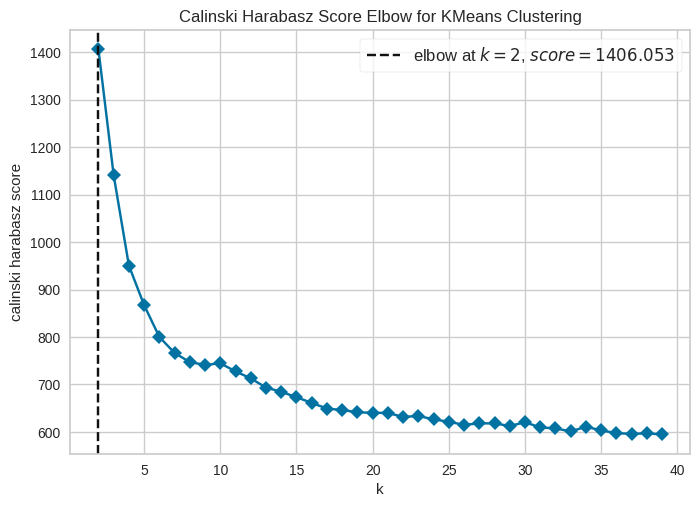

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [45]:
model = KMeans(n_init = n_init)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='calinski_harabasz', timings=False
)

visualizer.fit(x_minmax)        # Fit the data to the visualizer
visualizer.show()

## silhouette

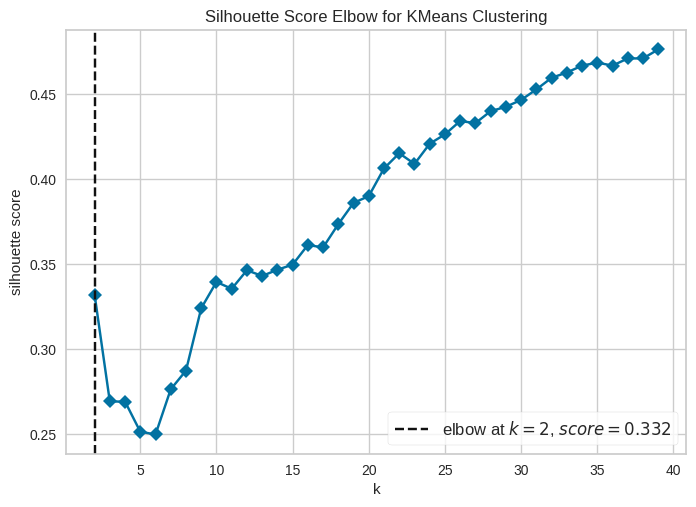

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [46]:
model = KMeans(n_init = n_init)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='silhouette', timings=False
)

visualizer.fit(x_minmax)        # Fit the data to the visualizer
visualizer.show() 

## distortion

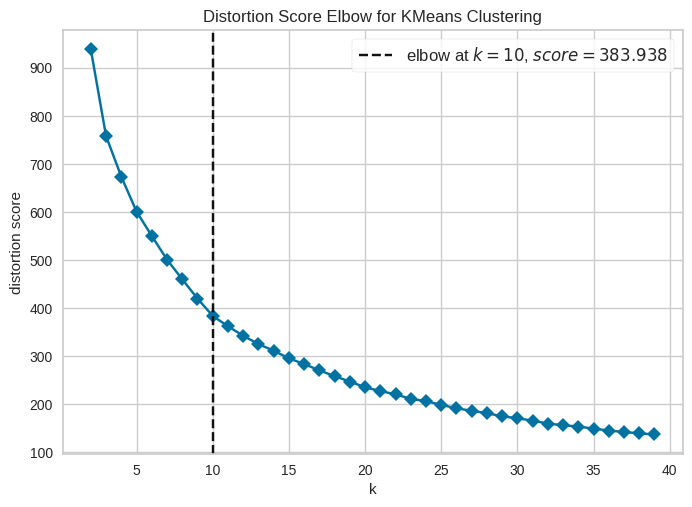

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
model = KMeans(n_init = n_init)
visualizer = KElbowVisualizer(
    model, k=(2,max_clusters), metric='distortion', timings=False
)

visualizer.fit(x_minmax)        # Fit the data to the visualizer
visualizer.show() 

## davies bouldin

<Axes: >

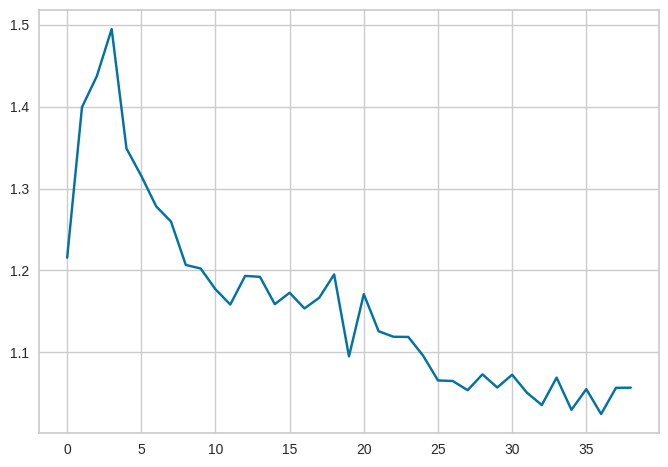

In [48]:
db = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_init = n_init, n_clusters = i)
    clusters = kmeans.fit_predict(x_minmax)
    db.append(davies_bouldin_score(x_minmax, clusters)) # lower values better clustering
s_db = pd.Series(db)
s_db.plot()

## clusters profiling

In [49]:
# avg simlarity of a cluster
# nr of rows
# or of unique values of each parameter
# count of each parameters value
# cluster performance:
   # avg of - avg sr, tr, % drawdown, drawdown duration, trades nr
   # avg of - std sr, tr
# cluster filter:
   # min of - min sr, tr, nr of trades
   # max of - max drawdown duration, std of sr, tr
# same on pct change variables

In [262]:
km_final = KMeans(n_init = n_init, n_clusters = 36)
km_final.fit(x_minmax)
predicted_clusters = km_final.predict(x_minmax)


In [263]:
pd.Series(predicted_clusters).value_counts()

6     177
8     153
11    113
2     103
18    102
24     85
13     84
30     82
5      81
28     77
12     71
29     69
25     67
0      65
1      64
4      62
33     59
3      59
14     58
26     55
17     53
10     53
7      53
27     52
9      43
34     42
15     37
19     36
31     35
23     35
35     30
22     29
32     27
16     26
20     24
21     19
Name: count, dtype: int64

In [264]:
df_cluster_x_minmax = pd.DataFrame(x_minmax)
df_cluster_x_minmax['cluster'] = predicted_clusters

def average_intra_cluster_similarity(group):
    pairwise_distances = pdist(group, metric='euclidean')
    return pairwise_distances.mean() if len(pairwise_distances) > 0 else 0

avg_similarity = df_cluster_x_minmax.groupby('cluster').apply(average_intra_cluster_similarity)
print(avg_similarity) # lower is better, eg. lower distance, eg. higher similarity


cluster
0     0.401616
1     0.395766
2     0.119444
3     0.497086
4     0.361232
5     0.180372
6     0.189011
7     0.241659
8     0.137985
9     0.206855
10    0.146028
11    0.254810
12    0.272091
13    0.209986
14    0.412414
15    0.451627
16    0.384941
17    0.208171
18    0.354424
19    0.214346
20    0.336521
21    0.297719
22    0.447724
23    0.496543
24    0.304532
25    0.337453
26    0.170744
27    0.132573
28    0.437759
29    0.421713
30    0.279047
31    0.559433
32    0.556346
33    0.141071
34    0.474209
35    0.688041
dtype: float64


In [265]:
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

df_cluster_stats = pd.concat([df_f, df_f_params], axis = 1)
df_cluster_stats['cluster'] = predicted_clusters
# Group by the 'cluster' column
cluster_groups = df_cluster_stats.groupby('cluster')

# Initialize a dictionary to hold your statistics
cluster_stats = {}

# Loop through each group to calculate statistics
for cluster, group in cluster_groups:
    stats = {
        'nr_of_rows': len(group),
        'avg': group[['Total Return [%]_in_mean', 'Sharpe Ratio_in_mean', 'Max Drawdown [%]_in_mean', 
                                  'Total Trades_in_mean', 'Total Return [%]_in_std_perc', 'Sharpe Ratio_in_std_perc',
                                  'Total Return [%]_pct_diff_mean', 'Sharpe Ratio_pct_diff_mean', 'Max Drawdown [%]_pct_diff_mean', 
                                  'Total Trades_pct_diff_mean', 'Total Return [%]_pct_diff_std', 'Sharpe Ratio_pct_diff_std']].mean().to_dict(),
        'min': group[['Sharpe Ratio_in_min', 'Total Return [%]_in_min', 'Total Trades_in_min',
                      'Sharpe Ratio_pct_diff_min', 'Total Return [%]_pct_diff_min', 'Total Trades_pct_diff_min']].min().to_dict(),
        'max': group[['Max Drawdown [%]_in_max', 'Sharpe Ratio_in_std_perc', 'Total Return [%]_in_std_perc',
                      'Max Drawdown [%]_pct_diff_max', 'Sharpe Ratio_pct_diff_std', 'Total Return [%]_pct_diff_std']].max().to_dict(),
        'unique_cnt': group[['custom_window_entry_identify', 'custom_window_entry_count', 'custom_hh_hl_counts', 
                                       'custom_window_exit_identify', 'custom_window_exit_count', 'custom_lh_counts']].nunique().to_dict(),
        'value_counts': group[['custom_window_entry_identify', 'custom_window_entry_count', 'custom_hh_hl_counts', 
                                       'custom_window_exit_identify', 'custom_window_exit_count', 'custom_lh_counts']].apply(pd.Series.value_counts).to_dict()
    }
    cluster_stats[cluster] = stats
    
df_cluster_stats_result = pd.DataFrame()
for key in cluster_stats.keys():
   # Flattening the nested dictionary
   flat_data = flatten_dict(cluster_stats[key])

   # Remove the separator at the beginning of the keys in the top level
   flat_data = {k.lstrip('_'): v for k, v in flat_data.items()}

   # Converting to Pandas Series
   series = pd.Series(flat_data)
   
   df_cluster_stats_result[f'cluster_{key}'] = series
   
df_similarity = pd.Series(avg_similarity).to_frame().T
df_similarity.columns = df_cluster_stats_result.columns
df_similarity.index = pd.Index(['avg_similarity'])

df_cluster_stats_result  = pd.concat([df_similarity, df_cluster_stats_result])

df_cluster_stats_result



,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35
avg_similarity,0.401616,0.395766,0.119444,0.497086,0.361232,0.180372,0.189011,0.241659,0.137985,0.206855,...,0.170744,0.132573,0.437759,0.421713,0.279047,0.559433,0.556346,0.141071,0.474209,0.688041
nr_of_rows,65.000000,64.000000,103.000000,59.000000,62.000000,81.000000,177.000000,53.000000,153.000000,43.000000,...,55.000000,52.000000,77.000000,69.000000,82.000000,35.000000,27.000000,59.000000,42.000000,30.000000
avg_Total Return [%]_in_mean,386.682677,112.315803,236.470236,341.052667,451.688472,421.179637,103.480572,367.815166,111.885847,630.650858,...,505.686001,326.144902,323.275147,269.226462,344.577353,125.090174,248.507099,410.625999,173.112948,447.161236
avg_Sharpe Ratio_in_mean,1.355070,0.938781,1.249434,1.317936,1.464977,1.413452,1.012487,1.361976,1.049531,1.569512,...,1.499641,1.318335,1.371397,1.271552,1.330906,1.019966,1.236461,1.426973,1.066326,1.398193
avg_Max Drawdown [%]_in_mean,32.934201,29.565163,32.559131,36.451386,39.071114,37.375515,23.231563,28.421405,26.888049,30.682910,...,36.416732,29.729509,35.769086,33.858330,31.327897,31.685056,35.832396,30.953417,33.131224,39.320728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
value_counts_custom_lh_counts_4,4.000000,6.000000,NaN,10.000000,5.000000,5.000000,NaN,3.000000,NaN,8.000000,...,1.000000,NaN,26.000000,36.000000,NaN,2.000000,8.000000,7.000000,42.000000,7.000000
value_counts_custom_lh_counts_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value_counts_custom_lh_counts_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
value_counts_custom_lh_counts_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [266]:
df_cluster_stats_result.to_csv('../data/df_cluster_stats_result.csv', header=True, index=True)
df_cluster_stats.to_csv('../data/df_cluster_stats.csv', header=True, index=False)

# choosing n param combinations

In [5]:
df_cluster_stats = pd.read_csv('../data/df_cluster_stats.csv')

In [6]:
df_top_params = df_cluster_stats.groupby('cluster').apply(lambda df: df.loc[(df['Total Trades_in_mean'] > 20) &
                                                                            (df['Sharpe Ratio_in_mean'] > 0.6) &
                                                                            (df['Total Return [%]_pct_diff_mean'] > -0.7),:].sort_values(by = 'Sharpe Ratio_in_std_perc').head(5))
df_top_params

Total Return [%]_in_mean  Sharpe Ratio_in_mean  \
cluster                                                        
1       1226                105.740720              0.962322   
3       1557                279.877799              1.240129   
        1538                279.877799              1.240129   
        1547                300.778259              1.263234   
        1587                300.778259              1.263234   
...                                ...                   ...   
35      1606                434.323625              1.378495   
        1604                434.323625              1.378495   
        119                 278.540703              1.273398   
        1603                505.663836              1.472372   
        151                 300.816039              1.327855   

              Max Drawdown [%]_in_mean  Total Trades_in_mean  \
cluster                                                        
1       1226                 25.554210                  20.2   
3       1557                 38.346259                  30.6   
        1538                 38.346259                  30.6   
        1547                 34.735969                  30.9   
        1587                 34.735969                  30.9   
...                                ...                   ...   
35      1606                 44.157248                  28.6   
        1604                 44.157248                  28.6   
        119                  36.169705                  45.4   
        1603                 43.706990                  27.9   
        151                  35.506431                  41.7   

              Total Return [%]_in_std_perc  Sharpe Ratio_in_std_perc  \
cluster                                                                
1       1226                      0.189586                  0.125563   
3       1557                      0.187922                  0.091917   
        1538                      0.187922                  0.091917   
        1547                      0.261261                  0.107466   
        1587                      0.261261                  0.107466   
...                                    ...                       ...   
35      1606                      0.305558                  0.132560   
        1604                      0.305558                  0.132560   
        119                       0.218483                  0.135384   
        1603                      0.348659                  0.136661   
        151                       0.231071                  0.140411   

              Total Return [%]_pct_diff_mean  Sharpe Ratio_pct_diff_mean  \
cluster                                                                    
1       1226                       -0.552090                    0.139720   
3       1557                       -0.661818                   -0.068013   
        1538                       -0.661818                   -0.068013   
        1547                       -0.695880                   -0.089814   
        1587                       -0.695880                   -0.089814   
...                                      ...                         ...   
35      1606                       -0.634157                   -0.187893   
        1604                       -0.634157                   -0.187893   
        119                        -0.625524                   -0.144217   
        1603                       -0.687071                   -0.227191   
        151                        -0.613543                   -0.134865   

              Max Drawdown [%]_pct_diff_mean  Total Trades_pct_diff_mean  ...  \
cluster                                                                   ...   
1       1226                       -0.542541                   -0.451087  ...   
3       1557                       -0.464667                   -0.492795  ...   
        1538                       -0.464667                   -0.492795  ...   
        1547     

In [7]:
params = df_top_params.iloc[:, -7:-1].apply(list, axis = 'columns').tolist()

params_dict = {'window_entry_identify': [item[0] for item in params], 
          'window_entry_count': [item[1] for item in params], 
          'hh_hl_counts': [item[2] for item in params],
          'window_exit_identify': [item[3] for item in params], 
          'window_exit_count': [item[4] for item in params], 
          'lh_counts': [item[5] for item in params]}

# daily returns of top params

In [8]:
btc_data_yf = yf.download("BTC-USD", start="2010-01-01", end="2024-01-01")
df_btc = btc_data_yf
df_btc.columns = [col.lower() for col in df_btc.columns]

price_close = df_btc['close']
price_open = df_btc['open'].shift(-1)



[*********************100%%**********************]  1 of 1 completed


In [9]:
# Define the strategy logic in a function
def strategy_logic(close, window_entry_identify, window_entry_count, hh_hl_counts, 
                   window_exit_identify, window_exit_count, lh_counts):
    #close = pd.Series(close.flatten())
    if isinstance(close, np.ndarray):
        close = pd.DataFrame(close)
    higher_highs = close > close.rolling(window=window_entry_identify, min_periods=1).max().shift(1)
    higher_lows = close > close.rolling(window=window_entry_identify, min_periods=1).min().shift(1)

    hh_count = higher_highs.rolling(window=window_entry_count).sum()
    hl_count = higher_lows.rolling(window=window_entry_count).sum()

    entry_signal = (hl_count.shift(1) >= hh_hl_counts) & (hh_count.shift(1) >= hh_hl_counts) & higher_lows

    lower_highs = close < close.rolling(window=window_exit_identify, min_periods=1).max().shift(1)
    lh_count = lower_highs.rolling(window=window_exit_count).sum()
    exit_signal = (lh_count >= lh_counts) & lower_highs

    return entry_signal, exit_signal

# Create a custom indicator using the IndicatorFactory
MyStrategy = vbt.IndicatorFactory(
    input_names=['close'],
    param_names=['window_entry_identify', 'window_entry_count', 'hh_hl_counts',
                 'window_exit_identify', 'window_exit_count', 'lh_counts'],
    output_names=['entry_signal', 'exit_signal']
).from_apply_func(strategy_logic)

indicator = MyStrategy.run(price_close, **params_dict)

# Backtest the strategy
entries = indicator.entry_signal
exits = indicator.exit_signal

pf = vbt.Portfolio.from_signals(price_close, 
                                entries, 
                                exits,
                                price = price_open,
                                fees=0.001, 
                                slippage=0.0001, 
                                freq='1D')

In [10]:
pf_result = pf.stats(agg_func= None)

In [11]:
daily_ret = pf.daily_returns()
daily_ret

custom_window_entry_identify    6                             4            \
custom_window_entry_count       4    7                        3             
custom_hh_hl_counts             4    4                        2             
custom_window_exit_identify     8    6    5    6    8    7    6    7    3   
custom_window_exit_count        4    7    7    4    4    4    7    6    7   
custom_lh_counts                2    4    4    3    3    3    3    3    3   
Date                                                                        
2014-09-17                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-18                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-19                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-20                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-21                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-12-27                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-28                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-29                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-30                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-31                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

custom_window_entry_identify       ...    6                                \
custom_window_entry_count          ...    5         4              8        
custom_hh_hl_counts                ...    4         4              3        
custom_window_exit_identify     5  ...    4    5    5    6    4    7    6   
custom_window_exit_count        6  ...    8    8    7    7    7    6    6   
custom_lh_counts                3  ...    4    4    4    4    4    3    3   
Date                               ...                                      
2014-09-17                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-18                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-19                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-20                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2014-09-21                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                           ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-12-27                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-28                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-29                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-30                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2023-12-31                    0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

custom_window_entry_identify    3    6    3  
custom_window_entry_count       4    8    4  
custom_hh_hl_counts             3    3    3  
custom_window_exit_identify     6    5    8  
custom_window_exit_count        3    7    3  
custom_lh_counts                2    3    2  
Date                                         
2014-09-17                    0.0  0.0  0.0  
2014-09-18                    0.0  0.0  0.0  
2014-09-19                    0.0  0.0  0.0  
2014-09-20                    0.0  0.0  0.0  
2014-09-21                    0.0  0.0  0.0  
...                           ...  ...  ...  
2023-12-27                    0.0  0.0  0.0  
2023-12-28                    0.0  0.0  0.0  
2023-12-29                    0.0  0.0  0.0  
2023-12-30                    0.0  0.0  0.0  
2023-12-31                    0.0  0.0  0.0  

[3393 rows x 85 columns]

<Axes: xlabel='Date'>

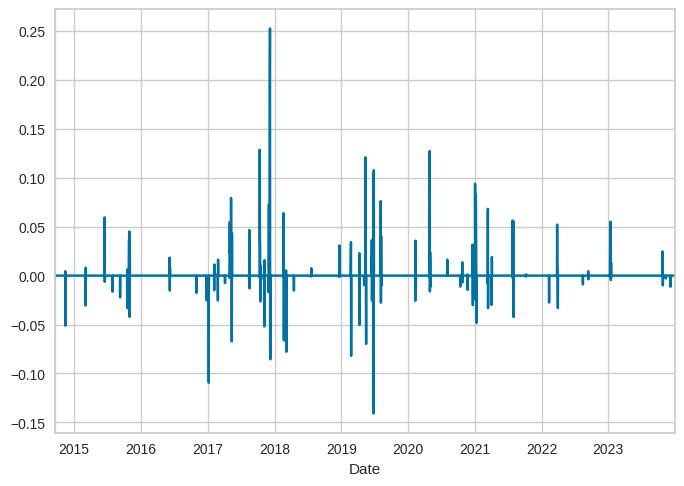

In [12]:
daily_ret.iloc[:, 0].plot()

In [13]:
df_corr = daily_ret.corr()
df_corr.head()

custom_window_entry_identify                                                                                                                             6  \
custom_window_entry_count                                                                                                                                4   
custom_hh_hl_counts                                                                                                                                      4   
custom_window_exit_identify                                                                                                                              8   
custom_window_exit_count                                                                                                                                 4   
custom_lh_counts                                                                                                                                         2   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   8                           4                        2                 1.000000   
                             7                         4                   6                           7                        4                 0.624783   
                                                                           5                           7                        4                 0.624783   
                                                                           6                           4                        3                 0.615375   
                                                                           8                           4                        3                 0.615375   

custom_window_entry_identify                                                                                                                                \
custom_window_entry_count                                                                                                                                7   
custom_hh_hl_counts                                                                                                                                      4   
custom_window_exit_identify                                                                                                                              6   
custom_window_exit_count                                                                                                                                 7   
custom_lh_counts                                                                                                                                         4   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   8                           4                        2                 0.624783   
                             7                         4                   6                           7                        4                 1.000000   
                                                                           5                           7                        4                 1.000000   
                                                                           6                           4                        3                 0.972323   
                                                                           8                           4                        3                 0.972323   

custom_window_entry_identify                                                                                                                                \
custom_window_entry_count                       

In [14]:
df_corr.min().min()

0.5402929725417888

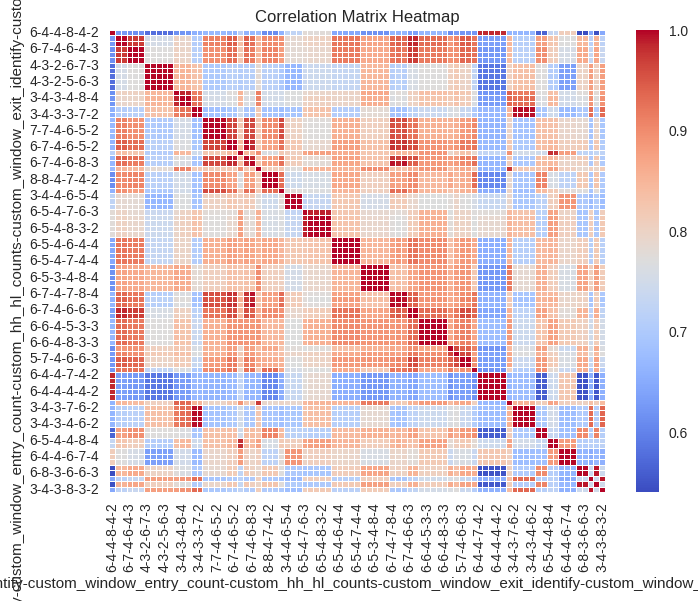

In [15]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

## hierarchical clustering method

In [16]:
# Convert correlation matrix to a distance matrix
dist_matrix = squareform(1 - df_corr)

# Apply hierarchical clustering
Z = linkage(dist_matrix, 'ward')

# Define the number of clusters
num_clusters = 5

# Assign cluster labels
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')

# Select one variable from each cluster
selected_vars = []
for i in range(1, num_clusters+1):
    cluster_vars = daily_ret.columns[cluster_labels == i]
    # You can choose different criteria for selection
    selected_vars.append(cluster_vars[0])  # Choosing the first variable as an example

print(selected_vars)

[(6, 4, 4, 8, 4, 2), (6, 5, 4, 3, 8, 4), (4, 3, 2, 6, 7, 3), (6, 7, 4, 6, 7, 4), (3, 4, 3, 3, 8, 4)]


In [17]:
daily_ret[selected_vars].corr()

custom_window_entry_identify                                                                                                                             6  \
custom_window_entry_count                                                                                                                                4   
custom_hh_hl_counts                                                                                                                                      4   
custom_window_exit_identify                                                                                                                              8   
custom_window_exit_count                                                                                                                                 4   
custom_lh_counts                                                                                                                                         2   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   8                           4                        2                 1.000000   
                             5                         4                   3                           8                        4                 0.716196   
4                            3                         2                   6                           7                        3                 0.576907   
6                            7                         4                   6                           7                        4                 0.624783   
3                            4                         3                   3                           8                        4                 0.612436   

custom_window_entry_identify                                                                                                                                \
custom_window_entry_count                                                                                                                                5   
custom_hh_hl_counts                                                                                                                                      4   
custom_window_exit_identify                                                                                                                              3   
custom_window_exit_count                                                                                                                                 8   
custom_lh_counts                                                                                                                                         4   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   8                           4                        2                 0.716196   
                             5                         4                   3                           8                        4                 1.000000   
4                            3                         2                   6                           7                        3                 0.708091   
6                            7                         4                   6                           7                        4                 0.837071   
3                            4                         3                   3                           8                        4                 0.851763   

custom_window_entry_identify                                                                                                                             4  \
custom_window_entry_count                       

In [21]:
pickle.dump(selected_vars, open('../data/top_params_hier_clust.pickle', 'wb'))

## pca method

In [18]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(daily_ret)

# Apply PCA
pca = PCA(n_components=5)
pca.fit(scaled_df)

# Get indices of the most important variable for each component, ensuring uniqueness
most_important_indices = set()
for component in pca.components_:
    for importance in np.argsort(np.abs(component))[::-1]:
        if importance not in most_important_indices:
            most_important_indices.add(importance)
            break

# Get the names of these variables
most_important_names = [daily_ret.columns[idx] for idx in most_important_indices]

print(most_important_names)

[(6, 4, 4, 3, 4, 2), (3, 4, 3, 3, 6, 2), (6, 5, 3, 6, 7, 4), (6, 7, 4, 5, 6, 3), (6, 5, 4, 3, 8, 4)]


In [19]:
daily_ret[most_important_names].corr()

custom_window_entry_identify                                                                                                                             6  \
custom_window_entry_count                                                                                                                                4   
custom_hh_hl_counts                                                                                                                                      4   
custom_window_exit_identify                                                                                                                              3   
custom_window_exit_count                                                                                                                                 4   
custom_lh_counts                                                                                                                                         2   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   3                           4                        2                 1.000000   
3                            4                         3                   3                           6                        2                 0.676461   
6                            5                         3                   6                           7                        4                 0.625927   
                             7                         4                   5                           6                        3                 0.643633   
                             5                         4                   3                           8                        4                 0.728048   

custom_window_entry_identify                                                                                                                             3  \
custom_window_entry_count                                                                                                                                4   
custom_hh_hl_counts                                                                                                                                      3   
custom_window_exit_identify                                                                                                                              3   
custom_window_exit_count                                                                                                                                 6   
custom_lh_counts                                                                                                                                         2   
custom_window_entry_identify custom_window_entry_count custom_hh_hl_counts custom_window_exit_identify custom_window_exit_count custom_lh_counts             
6                            4                         4                   3                           4                        2                 0.676461   
3                            4                         3                   3                           6                        2                 1.000000   
6                            5                         3                   6                           7                        4                 0.785221   
                             7                         4                   5                           6                        3                 0.722939   
                             5                         4                   3                           8                        4                 0.751085   

custom_window_entry_identify                                                                                                                             6  \
custom_window_entry_count                       

In [23]:
pickle.dump(most_important_names, open('../data/top_params_pca.pickle', 'wb'))